In [6]:
import sys
import numpy as np
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [7]:
#set bigger font sizes
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIG_SIZE = 20
plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE-3)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [8]:
# define theoretical CDF
def func(x,tau):
    return 1-np.exp(-x/tau)

In [9]:
fdir ='./'
fesfiles =['transitions.dat']
Temps =['300']
Labels = ['z2n']

Temperature = 300 
 ntraj = 51 




/tmp/ipykernel_2166343/292474719.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.step(x1*mu, y1, 'k-', lw=1.,color='black',label='data')
/tmp/ipykernel_2166343/292474719.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x1*mu,yfit,'b-', lw=3.,color='red',alpha=0.7,label='fit')


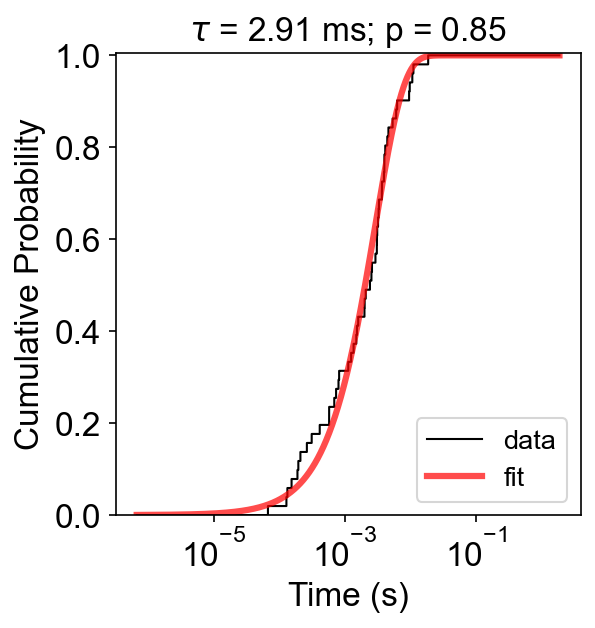

In [16]:
out=open('results-ks.dat','w')
for i in range(len(fesfiles)) :
    fesfile  = fdir+fesfiles[i] # realtime in S
    Temperature = Temps[i] # in K

    data = np.loadtxt(fesfile,usecols=(2))

    unrescaled_data = np.loadtxt(fesfile,usecols=(0))*1e-12 #in ps
    acc_factor = np.sum(data)/np.sum(unrescaled_data)

    ntraj = len(data)

    mint = min(data/100)
    maxt = max(data*100)

    ###########################
    # for numerical stability we divide by the mean
    mu = np.mean(data)
    sigma = np.std(data)
    t_m = np.median(data)

    x=data/mu
    # now compute empirical CDF
    ecdf = ECDF(x)
    x1 = np.logspace(np.log10(mint/mu), np.log10(maxt/mu),10000)
    y1 = ecdf(x1)
    # fit to theoretical CDF to obtain tau
    popt,pcov = curve_fit(func,x1,y1)
    tau=popt[0]
    yfit=func(x1,tau)

    ###########################
    # KS-test
    # generate random data with the same exponential distribution
    x2 = np.random.gamma(1,tau,10000000)
    st,pvalue = ks_2samp(x2,x)
    pvalue = '{:.10f}'.format(pvalue)
    str_tau=str(tau*mu)[:4]
    str_p=str(pvalue)[:4]

    print('Temperature = %s \n ntraj = %s \n mu = %s \n tau = %s \n mu_sem = %s \n sigma = %s \n t_m = %s \n K_value = %s \n mu_sigma_ratio = %s \n log2mu_median_ratio = %s \n tau_mu_ratio = %s \n pvalue_KS_statistic = %s \n acceleration_factor = %s \n'%(Temperature,ntraj,mu,tau*mu,sigma/np.sqrt(len(data)),sigma,t_m,1/(tau*mu),mu/sigma,np.log10(2)*mu/t_m,tau*mu/mu,pvalue,acc_factor)+'\n')

    fig = plt.figure(figsize=(4,4), dpi=150, facecolor='white')
    ax = fig.add_subplot(111)
    ax.step(x1*mu, y1, 'k-', lw=1.,color='black',label='data')
    ax.plot(x1*mu,yfit,'b-', lw=3.,color='red',alpha=0.7,label='fit')
    ax.legend(loc='lower right')
    ax.set_xscale('log')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cumulative Probability',fontname="Arial" )
    ax.set_xscale('log')
    ax.set_ylim(0,1.005)
    ax.set_title(r'$\tau$ = %.2f ms; p = %.2f'%(float(tau*mu*1000),float(pvalue)))
